In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 19 - Number concept development

## 19.1 Knower-level model for Give-N


$$ \pi \sim \text{Dirichlet}\overbrace{(1,...,1)}^{15} $$
$$ \nu \sim \text{Uniform}(1,1000)$$
$$ z_{i} \sim \text{Categorical}(\frac{1}{6},...,\frac{1}{6})$$  

$$ \pi^{\prime}_{ijk} \propto
\begin{cases}
\pi_k & \text{if $k \gt z_i$} \\
\nu \times \pi_{ijk} & \text{if $k \leq z_i$ and $k = q^g_{ij}$} \\
\frac{1}{\nu} \times \pi_{ijk} & \text{if $k \leq z_i$ and $k \neq q^g_{ij}$}
\end{cases}  $$  
$$ a_{ij}^g \sim \text{Categorical}(\pi^{\prime}_{ij})$$

In [2]:
import scipy.io as sio
matdata = sio.loadmat('data/fc_given.mat')

ns = np.squeeze(np.int64(matdata['ns']))
nz = np.squeeze(np.int64(matdata['nz']))
gnq = np.squeeze(np.int64(matdata['gnq']))
gn = np.squeeze(np.int64(matdata['gn']))
ga = np.squeeze(np.int64(matdata['ga']))
gq = np.squeeze(np.int64(matdata['gq']))

ind5 = np.zeros((nz, gn, gn), dtype=int)
for i in range(nz):
    for j in range(gn):
        for k in range(gn):
            # Will be 1 if Knower-Level (i.e, i-1) is Same or Greater than Answer
            ind1 = np.greater_equal(i-1, k)
            # Will be 1 for the Possible Answer that Matches the Question
            ind2 = k == j
            # Will be 1 for 0-Knowers
            ind3 = i == 0
            # Will be 1 for HN-Knowers
            ind4 = i == nz
            ind5[i, j, k] = ind3 + ind4*(2+ind2) + (1-ind4)*(1-ind3)*(ind1*ind2+ind1+1)
            

Assigned NUTS to pi_stickbreaking_
Assigned NUTS to nu_interval_
Assigned CategoricalGibbsMetropolis to zi
Assigned CategoricalGibbsMetropolis to predga


zi __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 3000/3000.0 [12:36<00:00,  3.66it/s]


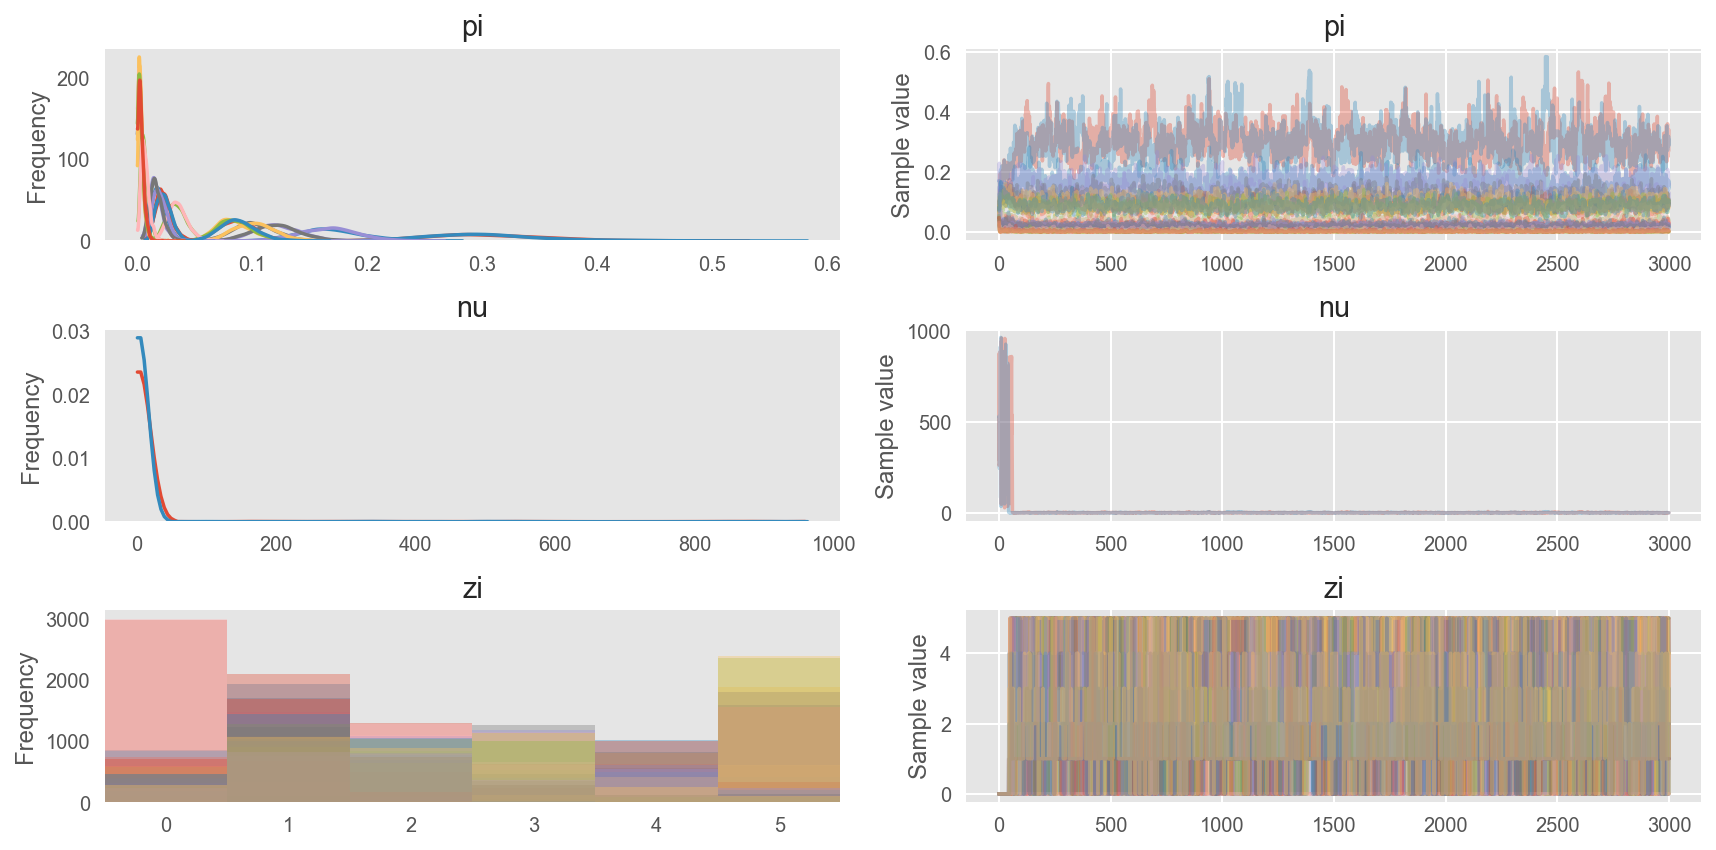

In [29]:
import theano

ind5r = ind5 - 1
ga_obs = np.asarray(ga.flatten()-1, dtype=int)
gq_obs = np.asarray(gq.flatten()-1, dtype=int)
valid_ind = np.where(gq_obs != -1)[0]

gqpred = np.tile(np.arange(gn)[np.newaxis, :], (ns, 1))
gqpred_flat = gqpred.flatten()

# This model is sensitive to the starting value - otherwise the trace doesnt move
# zi_tv = np.random.randint(low=0, high=nz, size=ns)

with pm.Model() as model1:
    pi = pm.Dirichlet('pi', a=np.ones(15), shape=15)
    
    nu = pm.Uniform('nu', lower=1, upper=1000)
    nu_vec = tt.stack([1, 1/nu, nu])
    
    piprime = tt.mul(nu_vec[ind5r], pi)
    npiprime = piprime / tt.sum(piprime, axis=-1, keepdims=True)
#     sumto1 = theano.gradient.zero_grad(
#             tt.le(abs(tt.sum(npiprime, axis=-1) - 1), 1e-5))
    
    zi = pm.Categorical('zi', p=np.ones(nz)/nz, shape=ns)
    zi_vec = tt.repeat(zi, gq.shape[1])
    zi_print = tt.printing.Print('zi')(zi)
    
    pi_ij = npiprime[zi_vec[valid_ind], gq_obs[valid_ind], :]

    aij = pm.Categorical('aij', p=pi_ij, observed=ga_obs[valid_ind])  #, shape=len(valid_ind))  #

    zi_vec2 = tt.repeat(zi, gn)
    pi_ij_pred = npiprime[zi_vec2, gqpred_flat, :]
    predga = pm.Categorical('predga', p=pi_ij_pred, shape=len(gqpred_flat)) 

    trace1 = pm.sample(3e3, njobs=2, target_accept=.95)
    
pm.traceplot(trace1, varnames=['pi', 'nu', 'zi'])
plt.show()

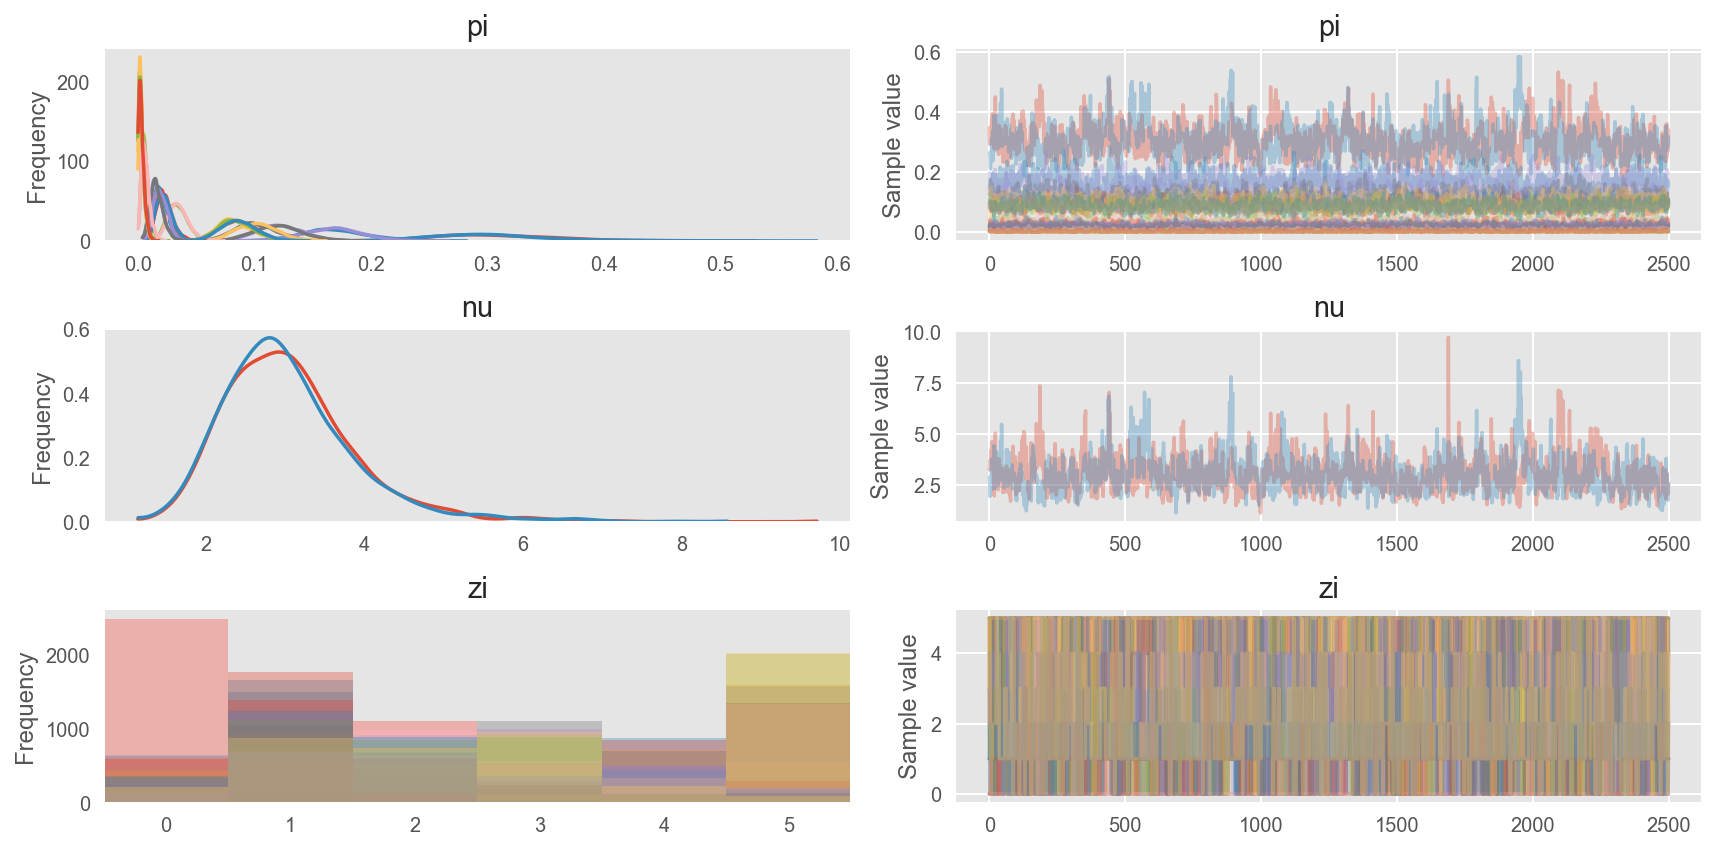

The accept rate is: 0.79872
Diverge of the trace
(array([], dtype=int64),)


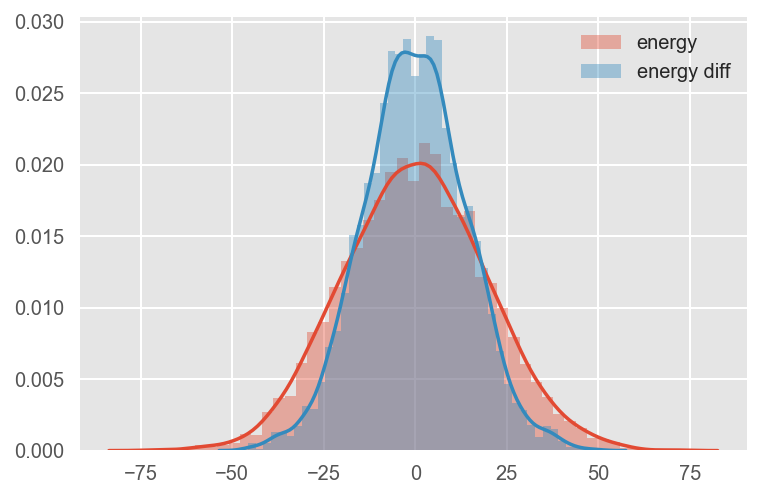

In [30]:
def plot_samplerstat(burnin,trace):
    # Sampler statistics
    accept = trace.get_sampler_stats('mean_tree_accept', burn=burnin)
    print('The accept rate is: %.5f' % (accept.mean()))
    diverge = trace.get_sampler_stats('diverging', burn=burnin)
    print('Diverge of the trace')
    print(diverge.nonzero())
    energy = trace.get_sampler_stats('energy', burn=burnin)
    energy_diff = np.diff(energy)
    sns.distplot(energy - energy.mean(), label='energy')
    sns.distplot(energy_diff, label='energy diff')
    plt.legend()
    plt.show()
    
burnin = 500
pm.traceplot(trace1[burnin:], varnames=['pi', 'nu', 'zi'])
plt.show()
plot_samplerstat(burnin,trace1)

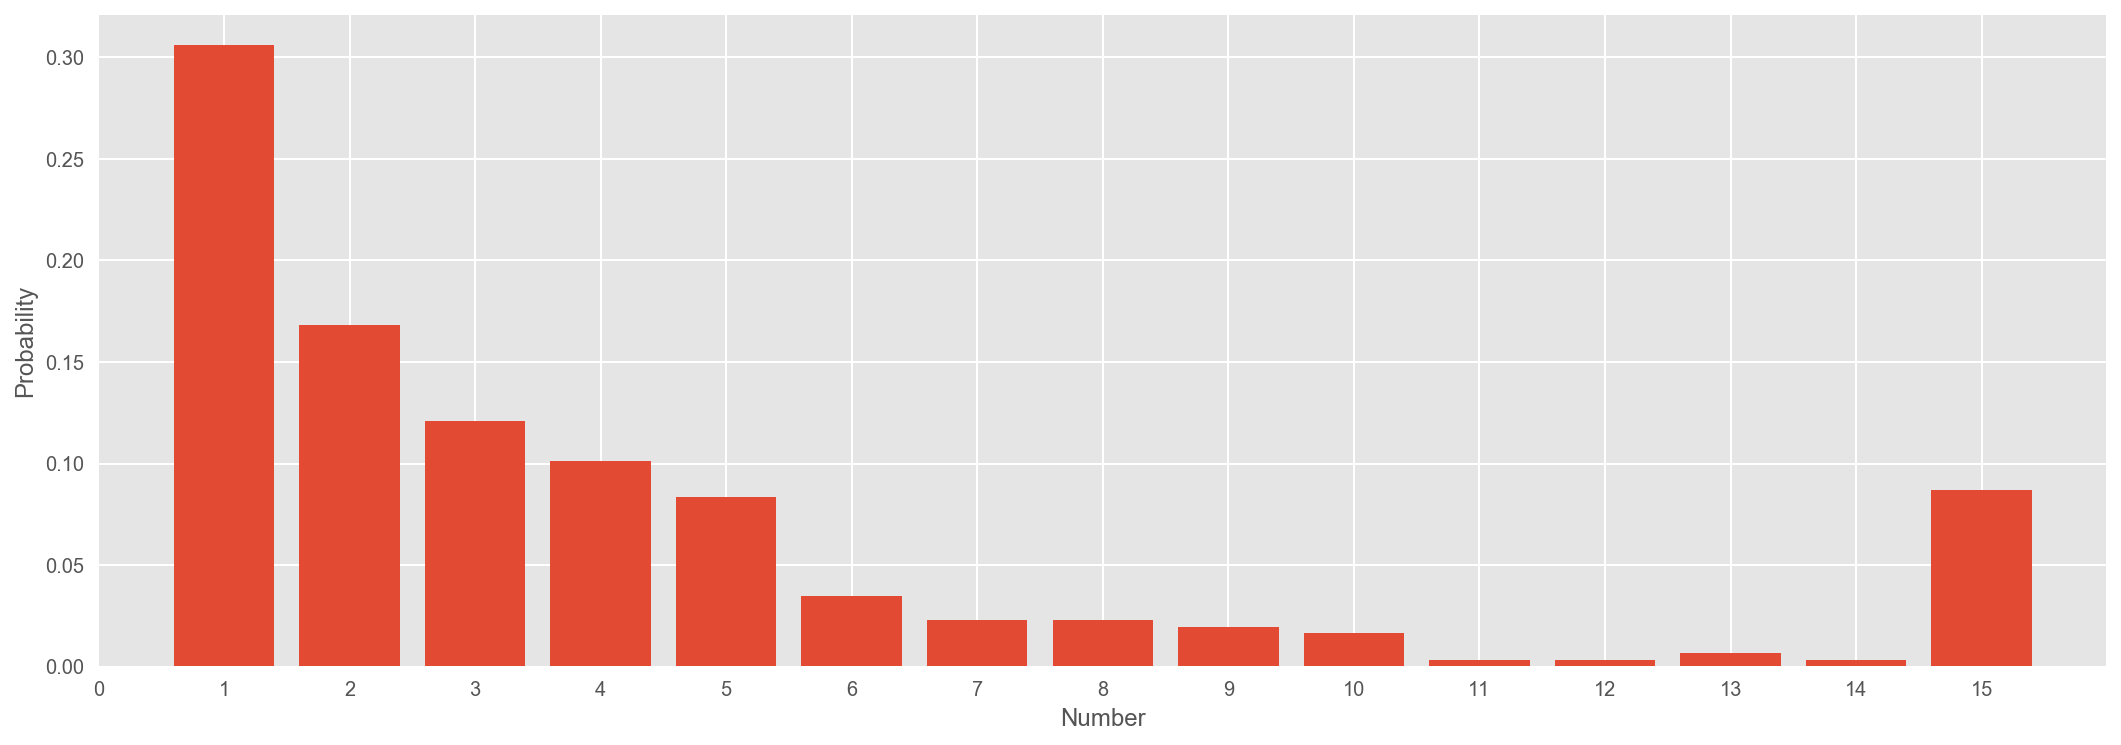

In [31]:
burnin = 500
pitr = trace1[burnin:]['pi']
fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(15)+1, np.mean(pitr, axis=0), align='center')
plt.xlabel('Number')
plt.ylabel('Probability')
plt.xticks(np.arange(16))
plt.xlim([0, 16])
plt.show()

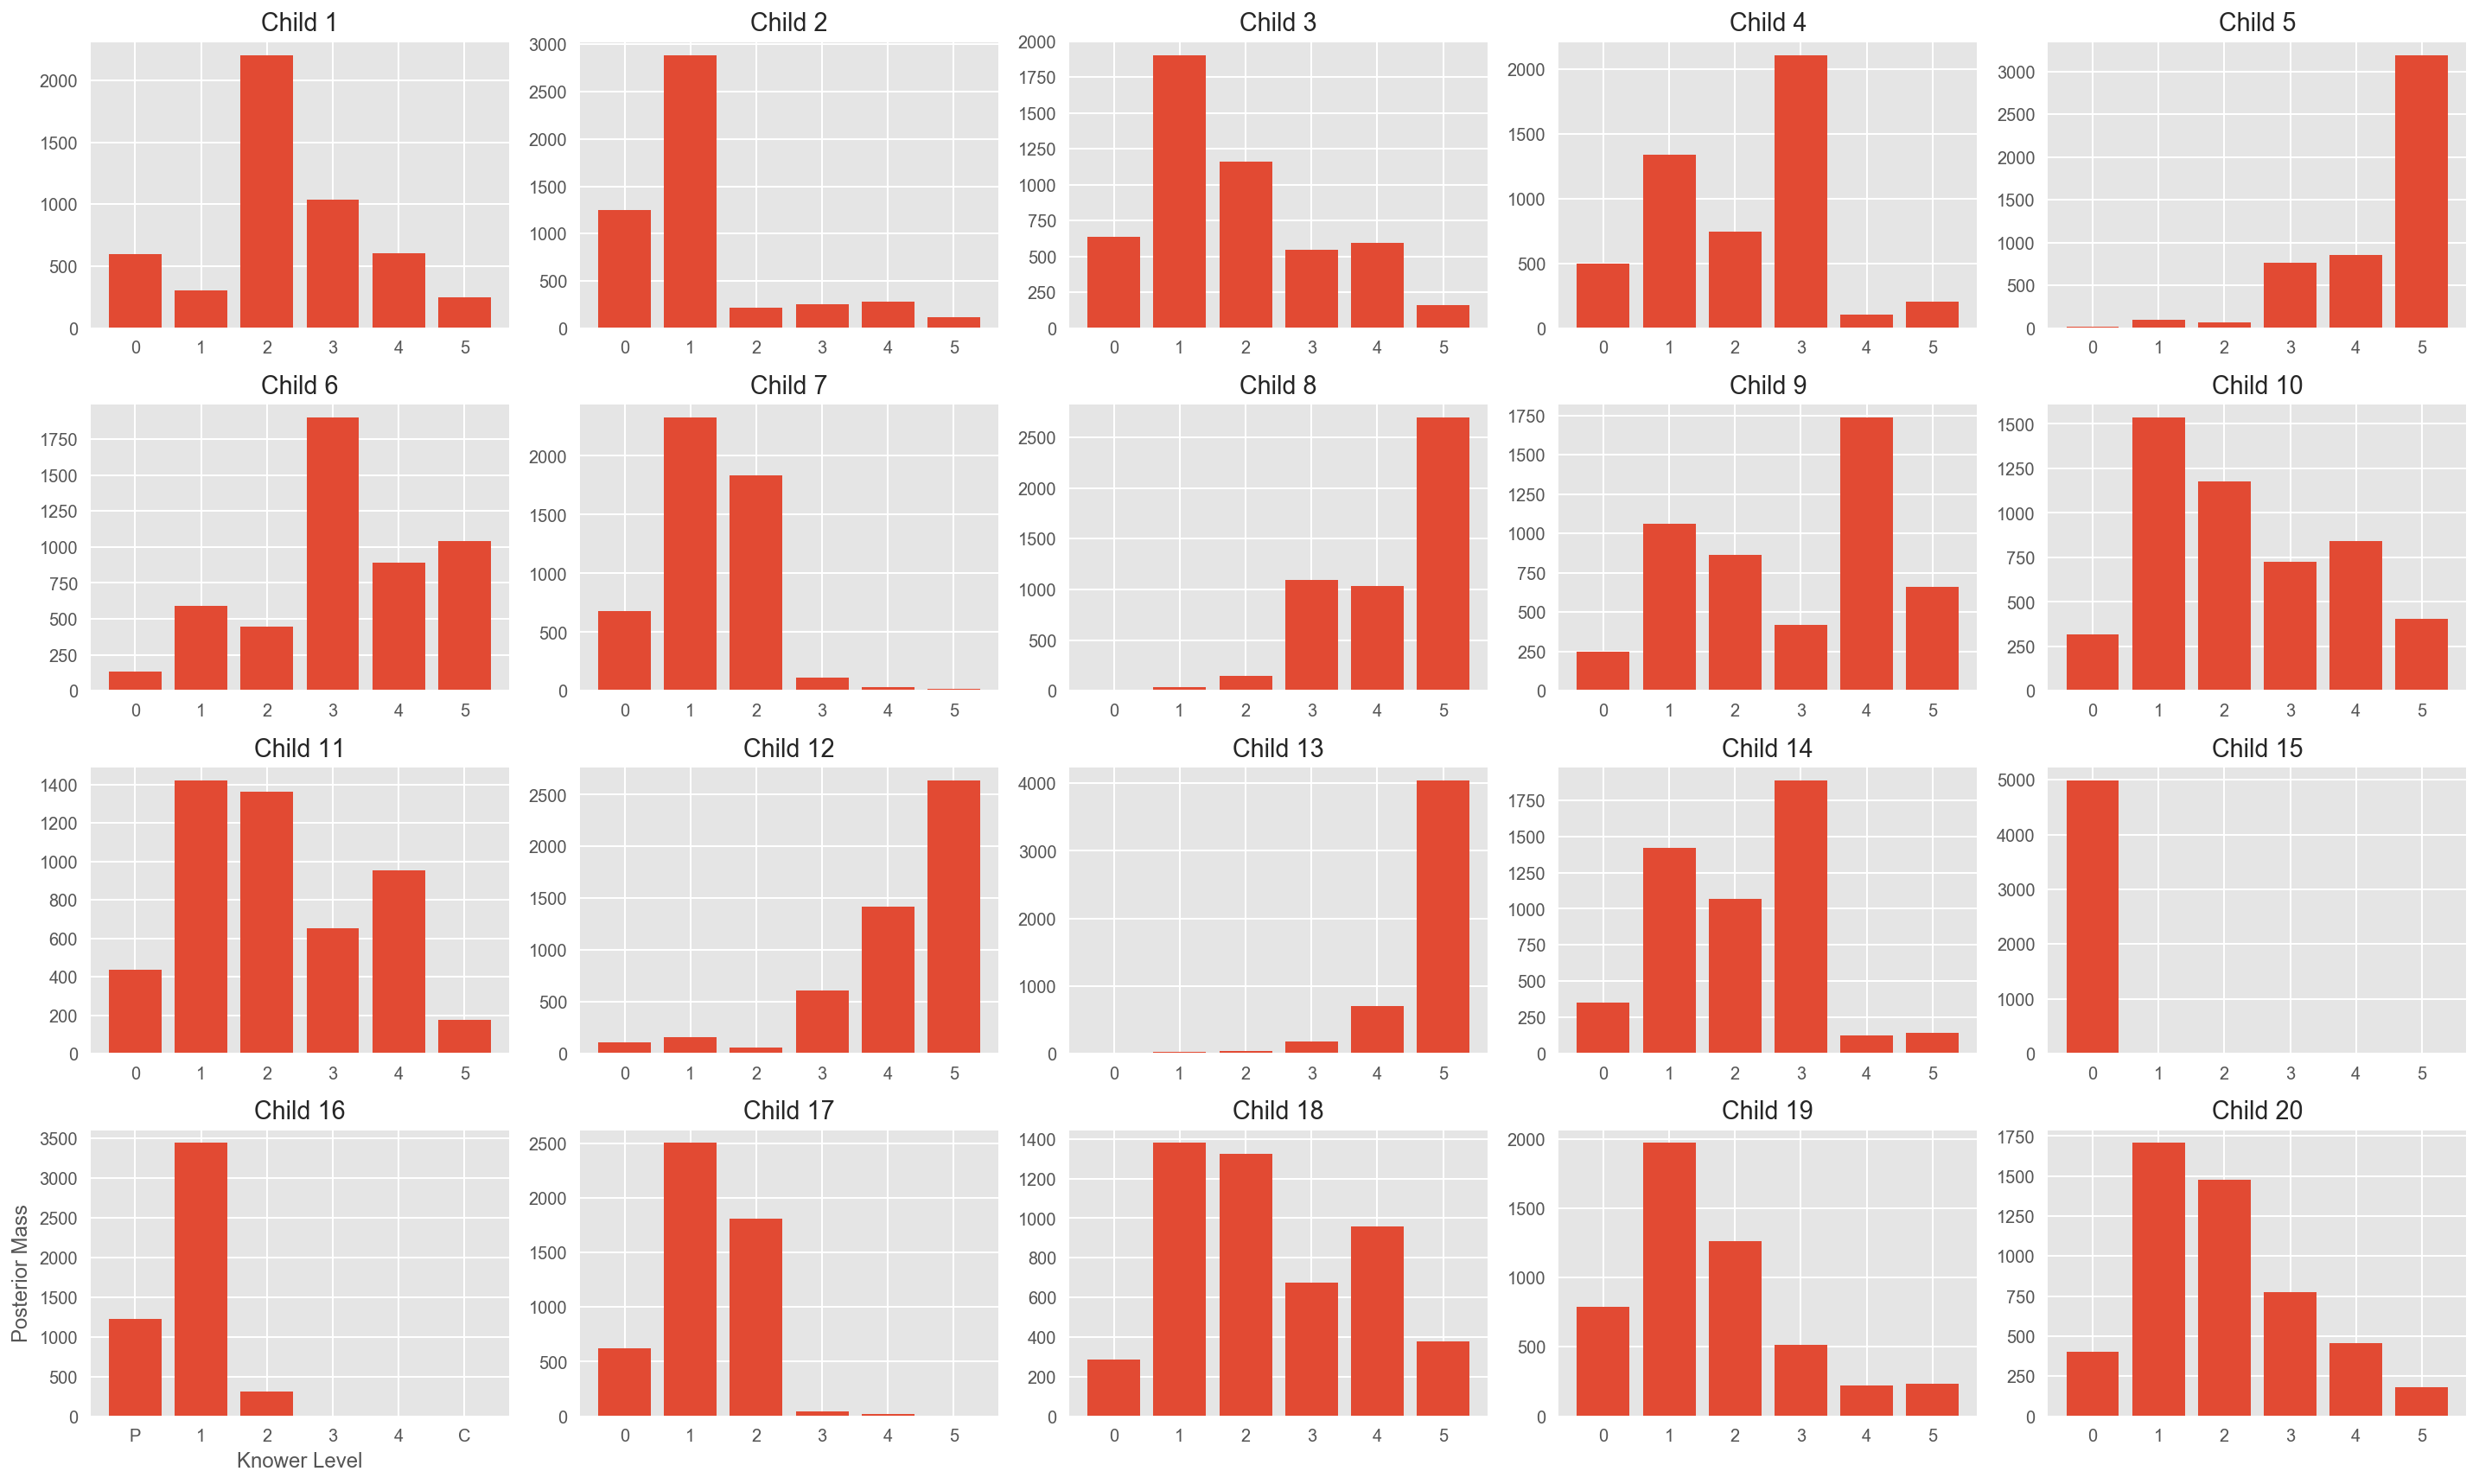

In [32]:
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(4, 5)
zitr = trace1[burnin:]['zi']
for i in range(ns):
    ax = plt.subplot(gs[i])
    bartmp = np.unique(zitr[:, i], return_counts=True)
    ax.bar(bartmp[0], bartmp[1])
    ax.set_title('Child %s'%(i+1))
    
plt.subplot(gs[15])
plt.xlabel('Knower Level')
plt.ylabel('Posterior Mass')
plt.xticks(np.arange(6), ['P', '1', '2', '3', '4', 'C'])
plt.tight_layout()
plt.show()

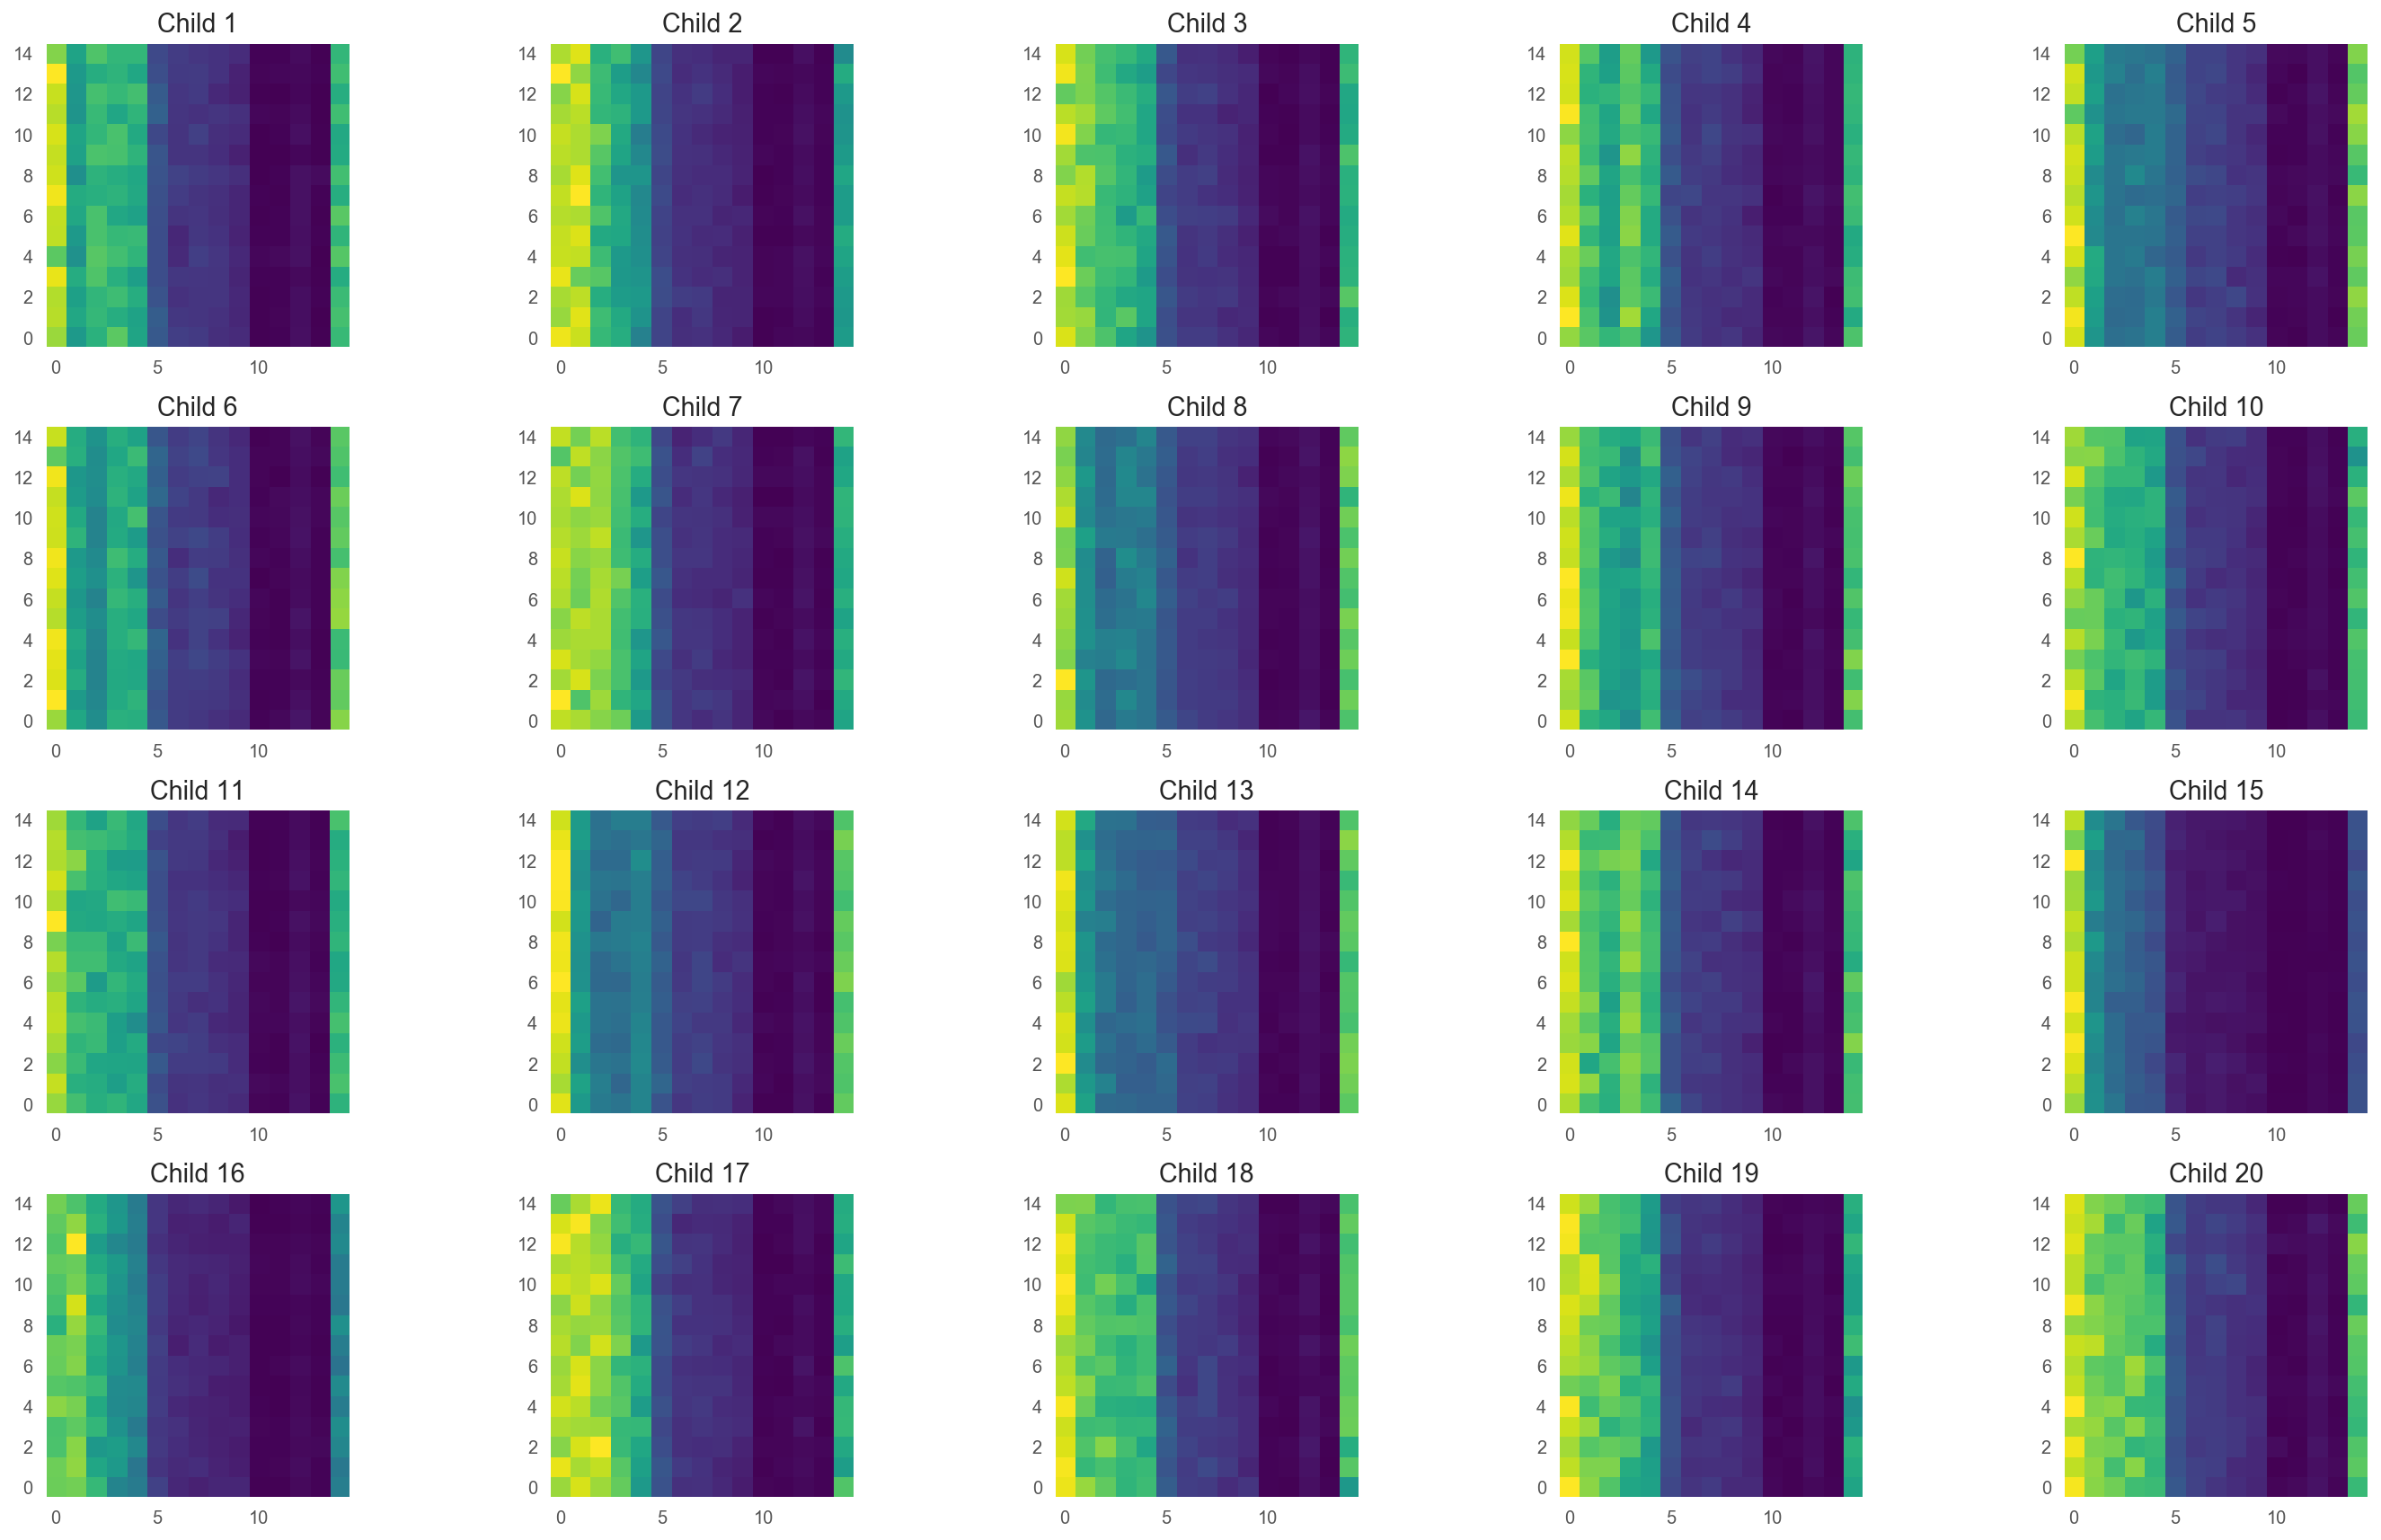

In [50]:
predi_ = trace1[burnin:]['predga']
nsample_ = predi_.shape[0]
predi_aij = np.reshape(predi_, newshape=(nsample_, ns, gn))

fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(4, 5)
for i in range(ns):
    mattmp = np.squeeze(predi_aij[:, i, :])
    img_ = np.zeros((gn, gn))
    for j in range(gn):
        bartmp = np.unique(mattmp[:, j], return_counts=True)
        img_[j, bartmp[0]] = bartmp[1]
    ax = plt.subplot(gs[i])
    ax.imshow(img_, cmap='viridis', origin='lower')
    ax.grid('off')
    ax.set_title('Child %s'%(i+1))
    
plt.tight_layout()
plt.show()

## 19.2 Knower-level model for Fast-Cards


$$ \pi \sim \text{Dirichlet}\overbrace{(1,...,1)}^{50} $$
$$ \nu \sim \text{Uniform}(1,1000)$$
$$ z_{i} \sim \text{Categorical}(\frac{1}{6},...,\frac{1}{6})$$  

$$ \pi^{\prime}_{ijk} \propto
\begin{cases}
\pi_k & \text{if $k \gt z_i$} \\
\nu \times \pi_{ijk} & \text{if $k \leq z_i$ and $k = q^f_{ij}$} \\
\frac{1}{\nu} \times \pi_{ijk} & \text{if $k \leq z_i$ and $k \neq q^f_{ij}$}
\end{cases}  $$  
$$ a_{ij}^f \sim \text{Categorical}(\pi^{\prime}_{ij})$$

## 19.3 Knower-level model for Give-N and Fast-Cards


$$ \pi^{g} \sim \text{Dirichlet}\overbrace{(1,...,1)}^{15} $$
$$ \pi^{f} \sim \text{Dirichlet}\overbrace{(1,...,1)}^{50} $$
$$ \nu^{g},\nu^{f} \sim \text{Uniform}(1,1000)$$
$$ z_{i} \sim \text{Categorical}(\frac{1}{6},...,\frac{1}{6})$$  

$$ \pi^{\prime g}_{ijk} \propto
\begin{cases}
\pi_k^g & \text{if $k \gt z_i$} \\
\nu^g \times \pi_{ijk}^g & \text{if $k \leq z_i$ and $k = q^f_{ij}$} \\
\frac{1}{\nu^g} \times \pi_{ijk}^g & \text{if $k \leq z_i$ and $k \neq q^f_{ij}$}
\end{cases}  $$  

$$ \pi^{\prime f}_{ijk} \propto
\begin{cases}
\pi_k^f & \text{if $k \gt z_i$} \\
\nu^f \times \pi_{ijk}^f & \text{if $k \leq z_i$ and $k = q^f_{ij}$} \\
\frac{1}{\nu^f} \times \pi_{ijk}^f & \text{if $k \leq z_i$ and $k \neq q^f_{ij}$}
\end{cases}  $$  

$$ a_{ij}^g \sim \text{Categorical}(\pi^{\prime g}_{ij})$$
$$ a_{ij}^f \sim \text{Categorical}(\pi^{\prime f}_{ij})$$